<a href="https://colab.research.google.com/github/Zver1952299/Virtual_teacher/blob/main/%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D0%BD%D0%B8%D0%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Введение

**Цель работы** — создание виртуального учителя по истории для школьников с использованием искусственного интеллекта и фреймворка LlamaIndex. Этот ИИ-помощник будет проводить увлекательные уроки, отвечать на вопросы учеников, помогать усваивать материал и проверять знания.

**Основные задачи проекта:**
1. **Создание базы знаний по истории** — сбор и подготовка материалов, которые будут использоваться для обучения модели.
2. **Интеграция с Hugging Face и LlamaIndex** — использование мощных моделей ИИ для обработки текста и построения индекса, что обеспечит быстрый поиск информации по материалам.
3. **Контекстное взаимодействие с пользователем** — система, которая будет учитывать историю общения, адаптируя уроки в зависимости от заданных вопросов и помогая глубже понять материал.
4. **Проверка знаний** — в конце каждого урока виртуальный учитель будет задавать вопросы для оценки усвоения материала, что помогает улучшить процесс обучения.

Проект создаёт интерактивную и персонализированную образовательную среду, демонстрируя потенциал ИИ в обучении, а также предоставляет разработчику ценный опыт в интеграции различных технологий.

# Реализация проекта

## 1.Установка необходимых библиотек в Google Colab

Для начала нужно установить все необходимые библиотеки для работы с моделью от Hugging Face и создания индекса документов с помощью LlamaIndex.

In [ ]:
!pip install llama-index llama-index-llms-huggingface llama-index-embeddings-huggingface arize-phoenix openinference-instrumentation-llama_index nemoguardrails

## 2.Импортирование нужных модулей

Импортируем модули для работы с LlamaIndex, Hugging Face и Phoenix:

In [ ]:
import os
from getpass import getpass
from huggingface_hub import login
from llama_index.core import Settings
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.llms.huggingface import HuggingFaceInferenceAPI
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import VectorStoreIndex
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core import SimpleDirectoryReader
from llama_index.core import PromptTemplate
from llama_index.core.postprocessor import LongContextReorder
from llama_index.core.retrievers import VectorIndexRetriever
from nemoguardrails import RailsConfig, LLMRails

import nest_asyncio
import phoenix as px

from phoenix.evals import (
    HallucinationEvaluator,
    OpenAIModel,
    QAEvaluator,
    RelevanceEvaluator,
    run_evals,
)
from phoenix.session.evaluation import get_qa_with_reference, get_retrieved_documents
from phoenix.trace import DocumentEvaluations, SpanEvaluations
from openinference.instrumentation.llama_index import LlamaIndexInstrumentor
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter
from opentelemetry.sdk.trace import TracerProvider
from opentelemetry.sdk.trace.export import SimpleSpanProcessor

## 3.Настройка асинхронной работы и запуск Phoenix UI

Для работы с асинхронными вычислениями в Google Colab и визуализации трассировки вашего кода с помощью Phoenix UI:

In [ ]:
nest_asyncio.apply()

session = px.launch_app()

endpoint = "http://127.0.0.1:6006/v1/traces"
tracer_provider = TracerProvider()
tracer_provider.add_span_processor(SimpleSpanProcessor(OTLPSpanExporter(endpoint)))

LlamaIndexInstrumentor().instrument(skip_dep_check=True, tracer_provider=tracer_provider)

🌍 To view the Phoenix app in your browser, visit https://gn7rriiinva1-496ff2e9c6d22116-6006-colab.googleusercontent.com/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [ ]:
# После загрузки данных выводим ссылку на Phoenix UI для дальнейшего анализа результатов
print(f"🚀 Открой Phoenix UI для просмотра результата трассировки по ссылке: {session.url}")

🚀 Открой Phoenix UI для просмотра результата трассировки по ссылке: https://gn7rriiinva2-496ff2e9c6d22116-6006-colab.googleusercontent.com/


## 4.Авторизация на Hugging Face


Запрашиваем токен для авторизации на Hugging Face, чтобы использовать модели:

In [ ]:
HF_TOKEN = getpass("Enter your Hugging Face token: ")
login(HF_TOKEN)

Enter your Hugging Face token: ··········


## 5.Загрузка данных для создания индекса

Загружаем необходимые данные и создаем индекс документов с помощью LlamaIndex:

In [ ]:
!mkdir -p 'db/'
!gdown 1QNu8SEwQgxUW9l-zwESBjjs6vzFFJbEL -O /content/db/

documents = SimpleDirectoryReader(input_dir="./db/").load_data()

Downloading...
From: https://drive.google.com/uc?id=1QNu8SEwQgxUW9l-zwESBjjs6vzFFJbEL
To: /content/db/data.json
100% 35.4k/35.4k [00:00<00:00, 55.2MB/s]


## 6.Настройка LlamaIndex и создание индекса

После загрузки данных настраиваем модель для обработки текста и эмбеддингов:

In [ ]:
# Настройка глобальных параметров для LlamaIndex
# Мы указываем модель для обработки текста (LLM) и модель для создания эмбеддингов
Settings.llm = HuggingFaceInferenceAPI(
    model_name="mistralai/Mistral-Nemo-Instruct-2407",
    token=HF_TOKEN,
    num_output=1024
)
Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")
Settings.chunk_size = 2048  # Размер чанков, на которые мы будем разбивать документы

# Создаём индекс документов, используя модель эмбеддингов
# Индекс будет хранить векторные представления документов, что позволяет быстро и эффективно искать информацию
index = VectorStoreIndex.from_documents(documents)

# Настроим retriever, который будет искать и извлекать информацию из созданного индекса
# В данном случае, мы настроили извлечение 2 наиболее похожих документов для каждого запроса
retriever = VectorIndexRetriever(index=index, similarity_top_k=4)

# Используем LongContextReorder для изменения порядка контекста, чтобы улучшить результаты запросов
reorder = LongContextReorder()

# Создаём Query Engine, который будет выполнять запросы к нашему индексу и использовать postprocessors (например, reorder)
query_engine = RetrieverQueryEngine(
    retriever=retriever,
    node_postprocessors=[reorder]
)

<ipython-input-29-f0d2e6baf327>:3: DeprecationWarning: Call to deprecated class HuggingFaceInferenceAPI. (Deprecated in favor of `HuggingFaceInferenceAPI` from `llama-index-llms-huggingface-api` which should be used instead.)
  Settings.llm = HuggingFaceInferenceAPI(


## 7.История общения и создание промпта с контекстом

Создаём систему для хранения истории общения и добавляем контекст в запросы:

In [ ]:
# Словарь для хранения истории общения
chat_history = []

def update_chat_history(question, answer):
    """
    Добавляет вопрос и ответ в историю чата.
    """
    chat_history.append({"question": question, "answer": answer})
    # Удерживаем только последние N записей, чтобы не перегружать контекст
    if len(chat_history) > 5:  # Можно настроить количество сохраняемых записей
        chat_history.pop(0)

def create_prompt_with_context(user_input):
    """
    Создаёт системный промпт, включая историю общения.
    """
    context = "\n".join(
        f"Question: {entry['question']}\nAnswer: {entry['answer']}"
        for entry in chat_history
    )
    return f"""
    You are a virtual history teacher, helping students learn their lessons.
    Answer only in Russian. Use only the data from the provided document.
    See the context in the communication history.
    Greet the student and suggest all the lesson topics that are listed in the document. (example: Ancient Greece, the First World War).
    After choosing a topic, give a short lecture, then ask a question.

    Communication history:
    {context}

    New question: {user_input}
    Answer:
    """

## 8.Безопасность

Создаем фильтр, для выявления и блокировки нежелательных тем для разговора

In [ ]:
import getpass # для работы с паролями
import os      # для работы с окружением и файловой системой

# Запрос ввода ключа от OpenAI
os.environ["OPENAI_API_KEY"] = getpass.getpass("Введите OpenAI API Key:")

Введите OpenAI API Key:··········


In [ ]:
config = """
models:
  - type: main
    engine: openai
    model: gpt-3.5-turbo-instruct
"""
rails = """
# define limits
define user ask weapon
    "Как сделать оружие?"
    "Где купить нож или пистолет?"
    "Как изготовить пули для автомата?"
    "Как сделать заточку?"

define bot answer weapon
    "Извини, я не могу говорить на тему оружия."

define flow weapon
    user ask weapon
    bot answer weapon
"""

In [ ]:
from nemoguardrails import RailsConfig, LLMRails

config = RailsConfig.from_content(
    colang_content=rails,
    yaml_content=config
)
rails = LLMRails(config)

/usr/local/lib/python3.11/dist-packages/nemoguardrails/rails/llm/llmrails.py:408: LangChainDeprecationWarning: The class `OpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAI``.
  self.llm = provider_cls(**kwargs)


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

## 8.Пример взаимодействия с пользователем

Пример взаимодействия с пользователем, где модель отвечает на вопросы:

In [ ]:
# Функция обьединяющая фильтрацию и генерацию ответа
def process_for_example(query):
    user_message = {"role": "user", "content": query}
    bot_response = rails.generate(messages=[user_message])

    if bot_response["content"].startswith("Извини"):
        return bot_response["content"]

    prompt = create_prompt_with_context(query)

    # Выполняем запрос к модели
    response = query_engine.query(prompt)

    # Сохраняем результат в историю общения
    update_chat_history(query, response.response)

    return response.response

In [ ]:
# Пример: пользователь приветсвует учителя
user_question = "Привет"

response = process_for_example(user_question)

# Выводим ответ
from IPython.display import display, Markdown
display(Markdown(response))

 Привет, ученик! Я твой виртуальный учитель истории. Сегодня мы можем изучить Первую мировую войну, Древний Рим или Древнюю Грецию. Какой из этих периодов истории тебя больше интересует?

In [ ]:
# Пример: пользователь выбирает тему урока
user_question = "Я хотел бы изучить тему Первая мировая война"

response = process_for_example(user_question)

# Выводим ответ
display(Markdown(response))

 Отличный выбор! Первая мировая война была одним из самых разрушительных конфликтов в истории. Началась она в 1914 году и длилась до 1918 года. В ней участвовали страны всего мира, в том числе Германия, Россия, Франция, Великобритания и США. Война была вызвана напряжённостью между великими державами, усиленной союзами и гонкой вооружений. Основной причиной войны стало убийство эрцгерцога Фердинанда в Сараево. Во время войны были использованы новые технологии, такие как танки и самолёты, а также химическое оружие. Война привела к значительным политическим, социальным и экономическим изменениям в мире. Какие факторы, на твой взгляд, способствовали началу Первой мировой войны?

In [ ]:
# Пример: пользователь отвечает на вопрос учителя и получает ответ
user_question = "Этот фактор убийство эрцгерцога Франца Фердинанда"

response = process_for_example(user_question)

# Выводим ответ
display(Markdown(response))

 Да, убийство эрцгерцога Франца Фердинанда в Сараево стало непосредственным поводом для начала Первой мировой войны. Однако, как я уже сказал, tensions между великими державами и гонка вооружений также сыграли важную роль в эскалации конфликта. Кроме того, система союзов, в которой страны были разделены на противоборствующие блоки, способствовала распространению войны по всему миру.

In [ ]:
# Пример: блокирова нежелательных тем разговора
user_question = "Как изготовить пистолет?"

response = process_for_example(user_question)

# Выводим ответ
display(Markdown(response))

Извини, я не могу говорить на тему оружия.

# При трассеровки в модель передются нужные данные.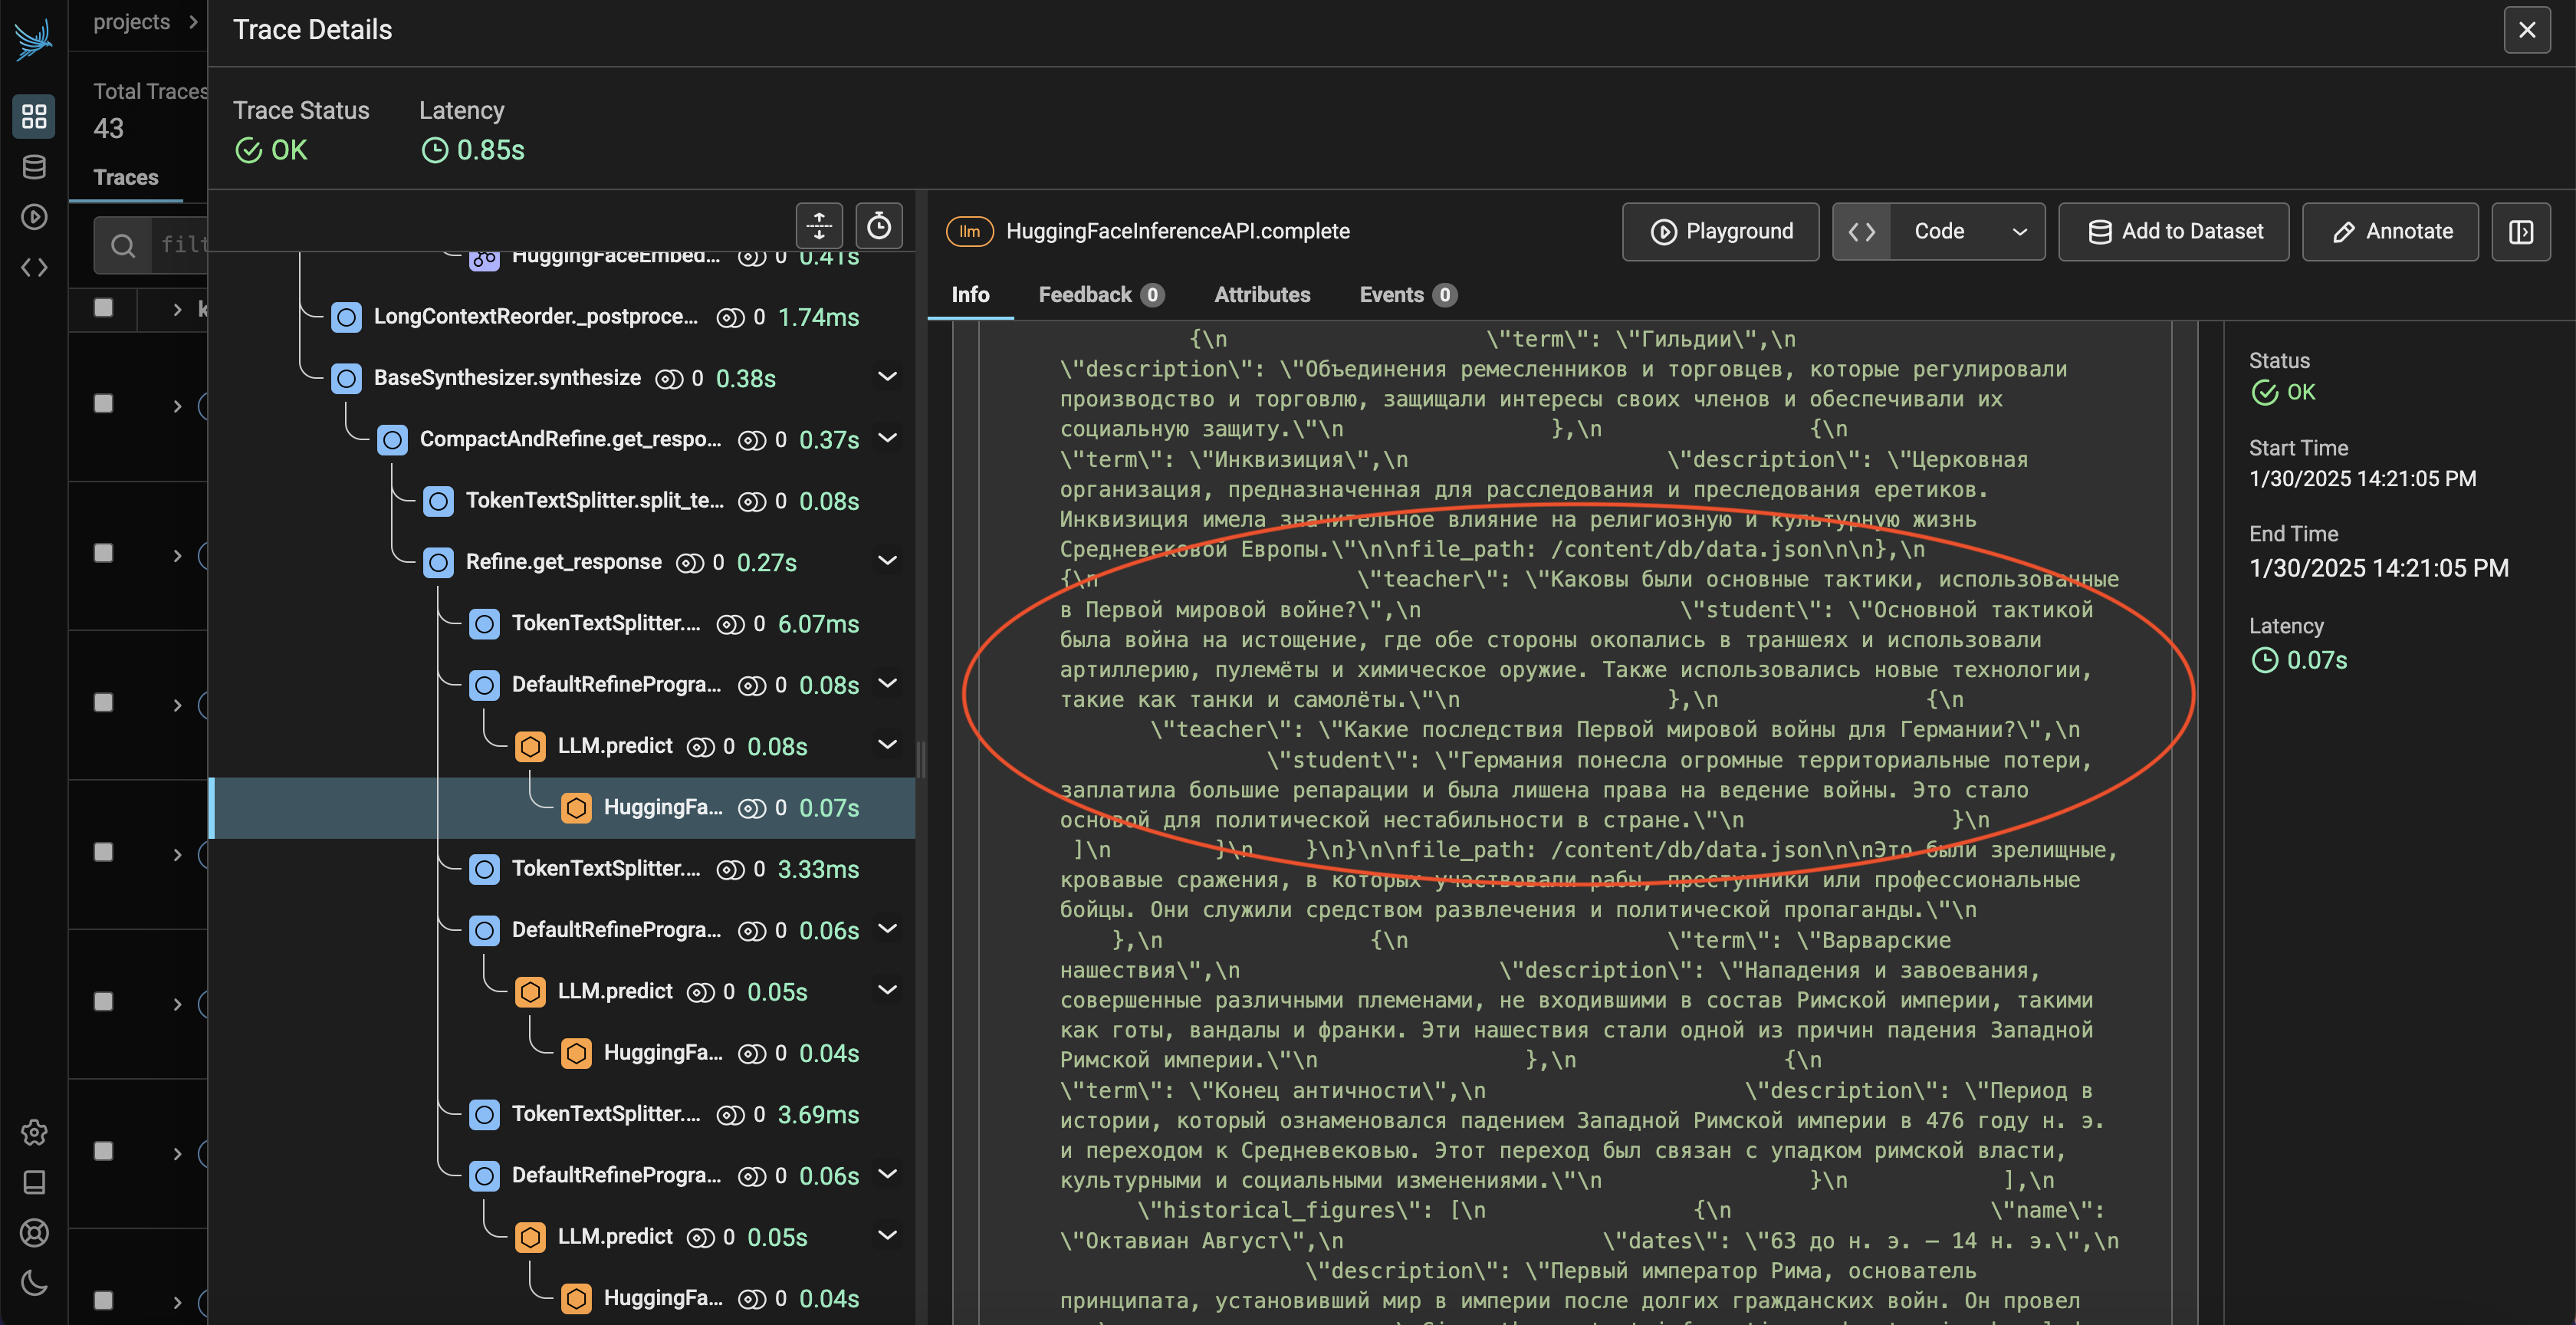

Для улучшения RAG системы я использовал следующие приемы:

**Использование длинных контекстов (LongContextReorder)** — этот подход помогает улучшить порядок представления контекста при ответах, что позволяет более эффективно обрабатывать длинные и сложные запросы, улучшая точность ответа.

**Контекстное взаимодействие с пользователем (chat history)** — использование истории общения позволяет модели учитывать предыдущие вопросы и ответы, что делает ответы более последовательными, контекстно зависимыми и логичными в рамках текущего диалога.

Проблему возможных галлюцинаций в системе RAG, когда модель может генерировать ложную информацию, я решил, ограничив её использование только информацией из предоставленного источника. Это было реализовано путем явного указания в промпте, что модель должна опираться исключительно на данные из предоставленного документа. Такой подход минимизирует риски ошибок и ложных утверждений, повышая точность и надежность ответов системы.